In [1]:
import torch
import gc
import pickle
import random
from torch.utils.data import DataLoader
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

ROOT_DIR = Path.cwd().parent
sys.path.append(str(ROOT_DIR))

from src.data import LOCCADataset  # noqa: E402, F401
from src.constants import BATCH_SIZE  # noqa: E402, F401
from src.module import LOCCAModel

LOCCA_DIR = ROOT_DIR / 'datasets/locca'
RESULTS_DIR = ROOT_DIR / 'results'

volumes_paths = np.array(sorted(LOCCA_DIR.glob('images*/*/*.nii.gz'), key=lambda p:p.name))

### Carregar dados de teste

In [ ]:
# Verificão
# pkls = {
#     1: [], # repet1
#     2: [], # repet2
#     3: [], # repet3
# }

# for pkl_path in sorted(RESULTS_DIR.glob('phase_1/pngs_paths/*/repet*/*.pkl')):
#     repet = int(pkl_path.parent.name[-1])

#     with open(pkl_path, 'rb') as f:
#         pkls[repet].append(pickle.load(f))


# for kfolditer in range(10):
#     assert pkls[1][kfolditer] == pkls[2][kfolditer] and pkls[2][kfolditer] == pkls[3][kfolditer]

#Ok. A divisão de dados de uma iteração do kfold é a mesma, para cada repetição.

In [ ]:
#TODO: dado um .ckpt, verificar repetição e iteração do kfold para obter os paths de teste

In [2]:
ckpt_path = RESULTS_DIR/'phase_1/DeepLabV3Plus_phase1_repet1_kfolditer0_epoch005_step10770_last_20260113-031046.ckpt'

In [3]:
import albumentations as A

test_transform = A.Compose([
    A.Resize(width=256, height=256),
    A.ToTensorV2(),
])

test_paths = []
with open(RESULTS_DIR/f'phase_1/pngs_paths/{ckpt_path.stem.split('_')[3]}_test.pkl', 'rb') as f:
    test_paths = pickle.load(f)

test_dataset = LOCCADataset(
    test_paths,
    test_transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4
)

In [6]:
def visualize_batch_overlay(batch, n_samples=4, alpha=0.5):
    volume = batch["volume"].squeeze(1)
    mask = batch["mask"]

    B = volume.shape[0]
    idxs = random.sample(range(B), min(n_samples, B))

    fig, axs = plt.subplots(len(idxs), 3, figsize=(6, 3 * len(idxs)))

    if len(idxs) == 1:
        axs = [axs]

    for lin, i in zip(axs, idxs):
        ct = volume[i].cpu().numpy()
        m = mask[i].cpu().numpy()

        lin[0].imshow(ct, cmap="gray")
        lin[0].set_title(f"slice [{i}]\nftype: {volume[i].cpu().dtype}")
        lin[0].axis("off")

        lin[1].imshow(m, cmap="Reds")
        lin[1].set_title(f"mask [{i}]\nvalues: {np.unique(m)}\ndtype: {mask[i].cpu().dtype}")
        lin[1].axis("off")

        lin[2].imshow(ct, cmap="gray")
        lin[2].imshow(m > 0, cmap="Reds", alpha=alpha)
        lin[2].set_title(f"Overlay slice [{i}]")
        lin[2].axis("off")

    plt.tight_layout()
    plt.show()




In [4]:
loader = iter(test_loader)

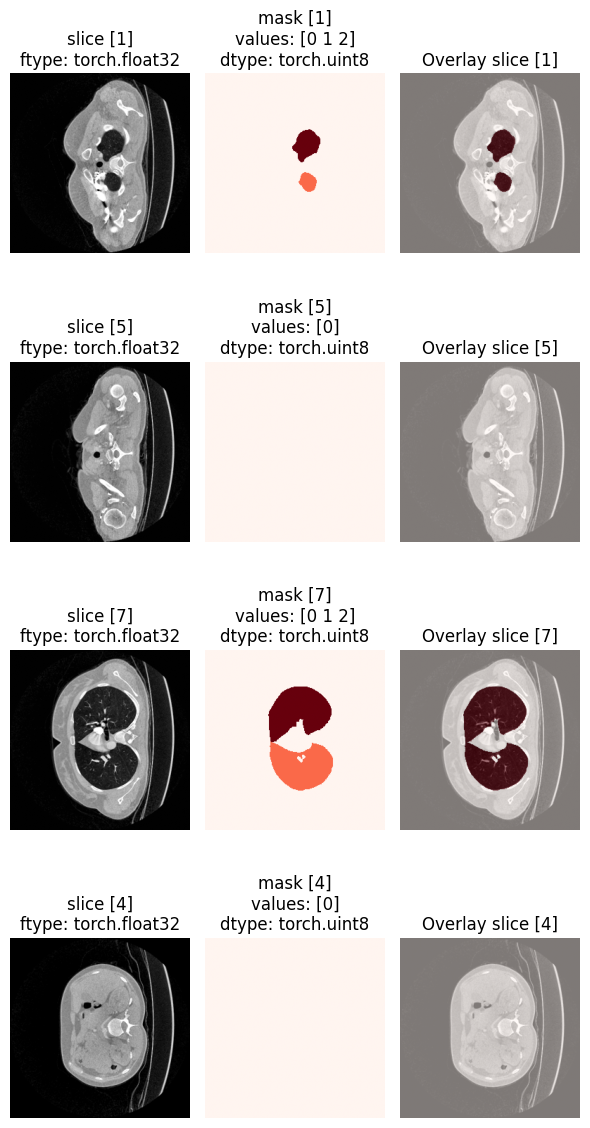

In [7]:
batch = next(loader)
visualize_batch_overlay(next(loader))

In [8]:
# Com base na docs do pytorch lightning:
model = LOCCAModel.load_from_checkpoint(
    ckpt_path,
    arch=ckpt_path.stem.split('_')[0],
    encoder_name='mobilenet_v2',
    in_channels=1,
    out_classes=3,
    phase=ckpt_path.parent.name,
    repetition=int(ckpt_path.stem.split('_')[2][-1]),
    kfolditer=int(ckpt_path.stem.split('_')[3][-1])
)

model.eval()

y_hat = model(batch['volume'])

In [9]:
y_hat.shape

torch.Size([8, 3, 256, 256])

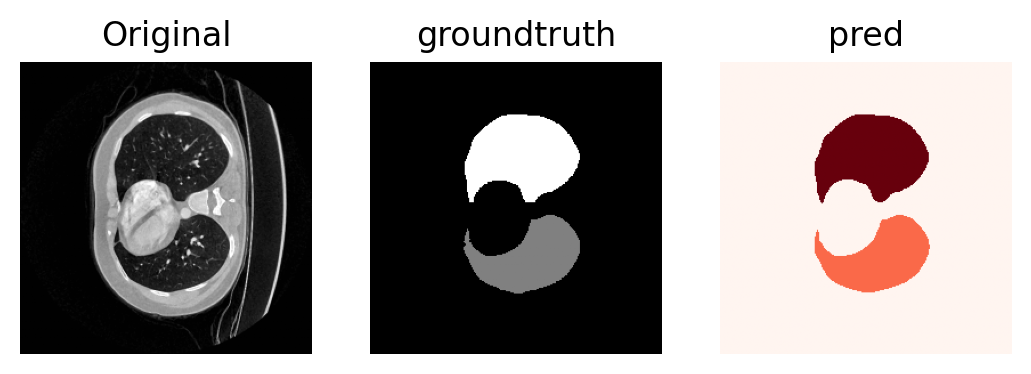

In [16]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, dpi=200)
slice = 4

axs[0].imshow(batch['volume'][slice].permute(1, 2, 0).detach().numpy(), cmap='gray')
axs[0].axis('off')
axs[0].set_title('Original')

axs[1].imshow(batch['mask'][slice].detach().numpy(), cmap='gray')
axs[1].axis('off')
axs[1].set_title('groundtruth')


pred = y_hat[slice].argmax(dim=0)

axs[2].imshow(pred, cmap='Reds')
axs[2].axis('off')
axs[2].set_title('pred')



plt.show()

fig.savefig(RESULTS_DIR/'phase_1/preds_vis/a_pred.png')
# plt.imshow(y_hat[0].permute(1, 2, 0).detach().numpy())
#TODO: fazer um código de visualização bonito